In [4]:
import cv2
import datetime
import math
import matplotlib.pyplot
import numpy
import os
import pathlib
import PIL
import skimage.morphology
import skimage.io
import sklearn
import sklearn.model_selection  
import sklearn.utils
import tensorflow

from albumentations import (
    Compose, HorizontalFlip, ShiftScaleRotate, ElasticTransform,
    RandomBrightness, RandomContrast, RandomGamma
)
from keras.preprocessing.image import array_to_img

In [5]:
class AugmentationSequence(tensorflow.keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size, augmentations):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations

    def __len__(self):
        return int(numpy.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        aug_x = numpy.zeros(batch_x.shape)
        aug_y = numpy.zeros(batch_y.shape)

        for idx in range(batch_x.shape[0]):
            aug = self.augment(image=batch_x[idx, :, :, :], mask=batch_y[idx, :, :, :])
            aug_x[idx, :, :, :] = aug["image"]
            aug_y[idx, :, :, :] = aug["mask"]

        return aug_x, aug_y

# Data

### Preprocess

In [6]:
def resize_image(image, image_size):
    return cv2.resize(image, (image_size, image_size), interpolation=cv2.INTER_CUBIC)


def return_all_images(dir):
    return [{"filename": file.name, "file": cv2.imread(str(file.resolve()), cv2.IMREAD_GRAYSCALE)}
            for file in pathlib.Path(dir).rglob("*")]


def create_if_not_exists_dir(dir):
    if not os.path.isdir(dir):
        os.makedirs(dir)

def only_resize(list_images, output_dir, image_size):
    create_if_not_exists_dir(output_dir)
    for image in list_images:
        cv2.imwrite(os.path.join(output_dir, image["filename"]), resize_image(image["file"], image_size))

def resize_all():
    list_images = return_all_images("new/images")
    list_mask = return_all_images("new/mask")
    only_resize(list_images, "images", 400)
    only_resize(list_mask, "mask", 400)

In [7]:
def load_mask(filename):
    return numpy.float32(skimage.io.imread(filename) / 255)

def load_all_masks(path):
    return [load_mask(filename) for filename in sorted(pathlib.Path(path).rglob("*"))]

def load_image(filename):
    return skimage.img_as_float32(skimage.io.imread(filename))

def load_all_images(path):
    return [load_image(filename) for filename in sorted(pathlib.Path(path).rglob("*"))]

def width_height_are_equal_image_size(image, image_size):
    return image.shape[0] == image_size and image.shape[1] == image_size

def validate_data(path, image_size):
    return all(not width_height_are_equal_image_size(skimage.io.imread(filename), image_size) for filename in sorted(pathlib.Path(path).rglob("*")))

# GPU

In [8]:
def set_avx_avx2():
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # INFO messages are not printed

def set_gpu():
    gpus = tensorflow.config.experimental.list_physical_devices("GPU")
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                print(f"GPU: {gpu.name}")
                tensorflow.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)

# Model

In [9]:
def unet_model(keras=None, img_size=None):

    input_img = tensorflow.keras.layers.Input((img_size, img_size, 1), name = "img")

    # Contract #1
    c1 = tensorflow.keras.layers.Conv2D(16, (3, 3), kernel_initializer = "he_uniform", padding = "same")(input_img)
    c1 = tensorflow.keras.layers.BatchNormalization()(c1)
    c1 = tensorflow.keras.layers.Activation("relu")(c1)
    c1 = tensorflow.keras.layers.Dropout(0.1)(c1)
    c1 = tensorflow.keras.layers.Conv2D(16, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c1)
    c1 = tensorflow.keras.layers.BatchNormalization()(c1)
    c1 = tensorflow.keras.layers.Activation("relu")(c1)
    p1 = tensorflow.keras.layers.MaxPooling2D((2, 2))(c1)

    # Contract #2
    c2 = tensorflow.keras.layers.Conv2D(32, (3, 3), kernel_initializer = "he_uniform", padding = "same")(p1)
    c2 = tensorflow.keras.layers.BatchNormalization()(c2)
    c2 = tensorflow.keras.layers.Activation("relu")(c2)
    c2 = tensorflow.keras.layers.Dropout(0.2)(c2)
    c2 = tensorflow.keras.layers.Conv2D(32, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c2)
    c2 = tensorflow.keras.layers.BatchNormalization()(c2)
    c2 = tensorflow.keras.layers.Activation("relu")(c2)
    p2 = tensorflow.keras.layers.MaxPooling2D((2, 2))(c2)

    # Contract #3
    c3 = tensorflow.keras.layers.Conv2D(64, (3, 3), kernel_initializer = "he_uniform", padding = "same")(p2)
    c3 = tensorflow.keras.layers.BatchNormalization()(c3)
    c3 = tensorflow.keras.layers.Activation("relu")(c3)
    c3 = tensorflow.keras.layers.Dropout(0.3)(c3)
    c3 = tensorflow.keras.layers.Conv2D(64, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c3)
    c3 = tensorflow.keras.layers.BatchNormalization()(c3)
    c3 = tensorflow.keras.layers.Activation("relu")(c3)
    p3 = tensorflow.keras.layers.MaxPooling2D((2, 2))(c3)

    # Contract #4
    c4 = tensorflow.keras.layers.Conv2D(128, (3, 3), kernel_initializer = "he_uniform", padding = "same")(p3)
    c4 = tensorflow.keras.layers.BatchNormalization()(c4)
    c4 = tensorflow.keras.layers.Activation("relu")(c4)
    c4 = tensorflow.keras.layers.Dropout(0.4)(c4)
    c4 = tensorflow.keras.layers.Conv2D(128, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c4)
    c4 = tensorflow.keras.layers.BatchNormalization()(c4)
    c4 = tensorflow.keras.layers.Activation("relu")(c4)
    p4 = tensorflow.keras.layers.MaxPooling2D((2, 2))(c4)

    # Middle
    c5 = tensorflow.keras.layers.Conv2D(256, (3, 3), kernel_initializer = "he_uniform", padding = "same")(p4)
    c5 = tensorflow.keras.layers.BatchNormalization()(c5)
    c5 = tensorflow.keras.layers.Activation("relu")(c5)
    c5 = tensorflow.keras.layers.Dropout(0.5)(c5)
    c5 = tensorflow.keras.layers.Conv2D(256, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c5)
    c5 = tensorflow.keras.layers.BatchNormalization()(c5)
    c5 = tensorflow.keras.layers.Activation("relu")(c5)

    # Expand (upscale) #1
    u6 = tensorflow.keras.layers.Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = "same")(c5)
    u6 = tensorflow.keras.layers.concatenate([u6, c4])
    c6 = tensorflow.keras.layers.Conv2D(128, (3, 3), kernel_initializer = "he_uniform", padding = "same")(u6)
    c6 = tensorflow.keras.layers.BatchNormalization()(c6)
    c6 = tensorflow.keras.layers.Activation("relu")(c6)
    c6 = tensorflow.keras.layers.Dropout(0.5)(c6)
    c6 = tensorflow.keras.layers.Conv2D(128, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c6)
    c6 = tensorflow.keras.layers.BatchNormalization()(c6)
    c6 = tensorflow.keras.layers.Activation("relu")(c6)

    # Expand (upscale) #2
    u7 = tensorflow.keras.layers.Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = "same")(c6)
    u7 = tensorflow.keras.layers.concatenate([u7, c3])
    c7 = tensorflow.keras.layers.Conv2D(64, (3, 3), kernel_initializer = "he_uniform", padding = "same")(u7)
    c7 = tensorflow.keras.layers.BatchNormalization()(c7)
    c7 = tensorflow.keras.layers.Activation("relu")(c7)
    c7 = tensorflow.keras.layers.Dropout(0.5)(c7)
    c7 = tensorflow.keras.layers.Conv2D(64, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c7)
    c7 = tensorflow.keras.layers.BatchNormalization()(c7)
    c7 = tensorflow.keras.layers.Activation("relu")(c7)

    # Expand (upscale) #3
    u8 = tensorflow.keras.layers.Conv2DTranspose(32, (3, 3), strides = (2, 2), padding = "same")(c7)
    u8 = tensorflow.keras.layers.concatenate([u8, c2])
    c8 = tensorflow.keras.layers.Conv2D(32, (3, 3), kernel_initializer = "he_uniform", padding = "same")(u8)
    c8 = tensorflow.keras.layers.BatchNormalization()(c8)
    c8 = tensorflow.keras.layers.Activation("relu")(c8)
    c8 = tensorflow.keras.layers.Dropout(0.5)(c8)
    c8 = tensorflow.keras.layers.Conv2D(32, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c8)
    c8 = tensorflow.keras.layers.BatchNormalization()(c8)
    c8 = tensorflow.keras.layers.Activation("relu")(c8)

    # Expand (upscale) #4
    u9 = tensorflow.keras.layers.Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = "same")(c8)
    u9 = tensorflow.keras.layers.concatenate([u9, c1])
    c9 = tensorflow.keras.layers.Conv2D(16, (3, 3), kernel_initializer = "he_uniform", padding = "same")(u9)
    c9 = tensorflow.keras.layers.BatchNormalization()(c9)
    c9 = tensorflow.keras.layers.Activation("relu")(c9)
    c9 = tensorflow.keras.layers.Dropout(0.5)(c9)
    c9 = tensorflow.keras.layers.Conv2D(16, (3, 3), kernel_initializer = "he_uniform", padding = "same")(c9)
    c9 = tensorflow.keras.layers.BatchNormalization()(c9)
    c9 = tensorflow.keras.layers.Activation("relu")(c9)

    output = tensorflow.keras.layers.Conv2D(1, (1, 1), activation = "sigmoid")(c9)
    model = tensorflow.keras.Model(inputs = [input_img], outputs = [output])
    return model

In [10]:
def jaccard_distance_loss(y_true, y_pred, smooth = 100):
    intersection = tensorflow.keras.backend.sum(tensorflow.keras.backend.abs(y_true * y_pred), axis = -1)
    union = tensorflow.keras.backend.sum(tensorflow.keras.backend.abs(y_true) + tensorflow.keras.backend.abs(y_pred), axis = -1)
    jac = (intersection + smooth) / (union - intersection + smooth)
    loss = (1 - jac) * smooth
    return loss


def dice_coef(y_true, y_pred, smooth = 1):
    intersection = tensorflow.keras.backend.sum(tensorflow.keras.backend.abs(y_true * y_pred), axis = -1)
    union = tensorflow.keras.backend.sum(tensorflow.keras.backend.abs(y_true), -1) + tensorflow.keras.backend.sum(tensorflow.keras.backend.abs(y_pred), -1)
    return (2. * intersection + smooth) / (union + smooth)

# Image

In [24]:
def crop_image(img, mask):
  crop_mask = mask > 0
  m, n = mask.shape
  crop_mask0, crop_mask1 = crop_mask.any(0), crop_mask.any(1)
  col_start, col_end = crop_mask0.argmax(), n - crop_mask0[::-1].argmax()
  row_start, row_end = crop_mask1.argmax(), m - crop_mask1[::-1].argmax()
  return img[row_start:row_end, col_start:col_end], mask[row_start:row_end, col_start:col_end]

def process_pred_mask(pred_mask):
    open_pred_mask = skimage.morphology.erosion(pred_mask, skimage.morphology.square(5))
    open_pred_mask = skimage.morphology.dilation(open_pred_mask, skimage.morphology.square(5))
    return skimage.morphology.dilation(open_pred_mask, skimage.morphology.square(5))

def save_image_mask_predmask(filename, image, mask, pred_mask, post_pred_mask, image_original_mask, image_pred_mask):
    figure = matplotlib.pyplot.figure(figsize=(15, 10))
    figure.add_subplot(2, 3, 1).set_title("Original image", fontdict = {"fontsize":18})
    matplotlib.pyplot.imshow(skimage.img_as_ubyte(image), cmap = "gray")
    figure.add_subplot(2, 3, 2).set_title("Original mask", fontdict = {"fontsize":18})
    matplotlib.pyplot.imshow(skimage.img_as_ubyte(mask), cmap = "gray")
    figure.add_subplot(2, 3, 3).set_title("Predicted mask", fontdict = {"fontsize":18})
    matplotlib.pyplot.imshow(pred_mask, cmap = "gray")
    figure.add_subplot(2, 3, 4).set_title("Preprocessed mask", fontdict = {"fontsize":18})
    matplotlib.pyplot.imshow(post_pred_mask, cmap = "gray")
    figure.add_subplot(2, 3, 5).set_title("Image original mask", fontdict = {"fontsize":18})
    matplotlib.pyplot.imshow(image_original_mask, cmap = "gray")
    figure.add_subplot(2, 3, 6).set_title("Image pred mask", fontdict = {"fontsize":18})
    matplotlib.pyplot.imshow(image_pred_mask, cmap = "gray")
    f.savefig(filename)
  

def save_all_images(X, Y, data_type):
    for idx in range(0, X.shape[0]):
        test_img = X[idx,:,:,:].reshape((1, image_size, image_size, 1))
        test_mask = Y[idx,:,:,:].reshape((1, image_size, image_size, 1))
        pred_mask = model.predict(test_img)[0,:,:,0]
        image_pred_mask = pred_mask
        pred_mask = numpy.uint8(pred_mask > 0.5)

        open_pred_mask = skimage.morphology.erosion(pred_mask, skimage.morphology.square(5))
        open_pred_mask = skimage.morphology.dilation(open_pred_mask, skimage.morphology.square(5))
        post_pred_mask = skimage.morphology.dilation(open_pred_mask, skimage.morphology.square(5))
        image_out_folder = os.path.join(out_folder, data_type, f"{idx}")

        # crop_img, crop_mask = crop_image(test_img[0,:,:,0], post_pred_mask) # keep
        crop_img_masked = test_img[0,:,:,0] * pred_mask
        mask_original = numpy.uint8(test_mask[0,:,:,0] > 0.5)
        crop_img_masked_original = test_img[0,:,:,0] * mask_original
        crop_img_masked[crop_img_masked == 0] = 1
        crop_img_masked_original[crop_img_masked_original == 0] = 1

        if not os.path.exists(image_out_folder):
            os.makedirs(image_out_folder)

        skimage.io.imsave(os.path.join(image_out_folder, f"{idx}-original.png"), skimage.img_as_ubyte(test_img[0,:,:,0]))    
        skimage.io.imsave(os.path.join(image_out_folder, f"{idx}-mask-original.png"), skimage.img_as_ubyte(test_mask[0,:,:,0]))    
        skimage.io.imsave(os.path.join(image_out_folder, f"{idx}-mask-unet.png"), skimage.img_as_ubyte(image_pred_mask))    
        # skimage.io.imsave(os.path.join(image_out_folder, f"{i}-post-pred-mask.png"), post_pred_mask * 255)    
        # skimage.io.imsave(os.path.join(image_out_folder, f"{i}-crop-img.png"), skimage.img_as_ubyte(crop_img))
        # skimage.io.imsave(os.path.join(image_out_folder, f"{i}-crop-mask.png"), crop_mask * 255)    
        skimage.io.imsave(os.path.join(image_out_folder, f"{idx}-crop-img-masked.png"), skimage.img_as_ubyte(crop_img_masked))
        skimage.io.imsave(os.path.join(image_out_folder, f"{idx}-crop-img-masked-original.png"), skimage.img_as_ubyte(crop_img_masked_original))    
        

        save_image_mask_predmask(os.path.join(image_out_folder, f"{idx}.png"), test_img[0,:,:,0], test_mask[0,:,:,0], pred_mask, post_pred_mask, crop_img_masked_original, crop_img_masked)


# Load data

In [12]:
path_mask = "mask"
path_images = "images"
image_size = 400

if validate_data(path_mask, image_size) and validate_data(path_images, image_size):
    raise SystemExit("err in input file")

images = load_all_images(path_images)
masks = load_all_masks(path_mask)

In [13]:
X = numpy.array(images).reshape(len(images), image_size, image_size, 1)
Y = numpy.array(masks).reshape(len(masks), image_size, image_size, 1)
X, Y = sklearn.utils.shuffle(X, Y, random_state=1234)

X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.05, random_state=1234)
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.05, random_state=1234)

print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")
print(f"X: {X.shape}")

X_train: (338, 400, 400, 1)
X_val: (18, 400, 400, 1)
X_test: (19, 400, 400, 1)
X: (375, 400, 400, 1)


In [14]:
%%capture
print(f"images[50].shape: {images[50].shape}")
print(f"masks[50].shape: {masks[50].shape}")
f = matplotlib.pyplot.figure()
f.add_subplot(3, 2, 1)
matplotlib.pyplot.imshow(images[50], cmap = "gray")
f.add_subplot(3, 2, 2)
matplotlib.pyplot.imshow(masks[50], cmap = "gray")

In [15]:
images_test_ids = []

nimages = X_test.shape[0]
for idx in range(nimages):
	test_image = X_test[idx,:,:,0]
	if any(numpy.array_equal(test_image, x) for x in images):
		images_test_ids.append(idx)

# Model configuration

In [16]:
learning_rate = 0.001
batch_size = 16
epochs = 100
steps_per_epoch = math.ceil(X_train.shape[0] / batch_size)

# Data augmentation

In [17]:
augment = Compose([
        HorizontalFlip(),
        ShiftScaleRotate(rotate_limit=45, border_mode=cv2.BORDER_CONSTANT),
        ElasticTransform(border_mode=cv2.BORDER_CONSTANT),
        RandomBrightness(),
        RandomContrast(),
        RandomGamma()
    ])

train_generator = AugmentationSequence(X_train, Y_train, batch_size, augment)

/home/xandao/miniconda3/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/xandao/miniconda3/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1639: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [18]:
%%capture
X_aug, Y_aug = train_generator.__getitem__(20)
f = matplotlib.pyplot.figure(figsize=(10, 10))
f.add_subplot(4, 2, 1)
matplotlib.pyplot.imshow(X_aug[0,:,:,0], cmap = "gray")
f.add_subplot(4, 2, 2)
matplotlib.pyplot.imshow(Y_aug[0,:,:,0], cmap = "gray")

f.add_subplot(4, 2, 3)
matplotlib.pyplot.imshow(X_aug[1,:,:,0], cmap = "gray")
f.add_subplot(4, 2, 4)
matplotlib.pyplot.imshow(Y_aug[1,:,:,0], cmap = "gray")

# Model

In [19]:
# unet_filename = os.path.join("model", f"batch{batch_size}+lr{str(learning_rate).replace('.', '_')}+epoch{epochs}+steps{steps_per_epoch}+unet.h5")
unet_filename = os.path.join("model", "batch4+lr0_05+epoch200+steps85+unet.h5")

reduce_learning_rate = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor = "loss", factor = 0.5, patience = 3, verbose = 1)

checkpointer = tensorflow.keras.callbacks.ModelCheckpoint(unet_filename, verbose = 1, save_best_only = True)

strategy = tensorflow.distribute.MirroredStrategy()

if (os.path.exists(unet_filename)):
	model = tensorflow.keras.models.load_model(unet_filename, custom_objects = {"jaccard_distance_loss": jaccard_distance_loss,"dice_coef": dice_coef})
else:
	with strategy.scope():
		model = unet_model()
		adam_opt = tensorflow.keras.optimizers.Adam(learning_rate = learning_rate)
		model.compile(optimizer = adam_opt, loss = jaccard_distance_loss, metrics = [dice_coef])
    
	fit = model.fit(train_generator, 
		steps_per_epoch = steps_per_epoch, 
		epochs = epochs,
		validation_data = (X_val, Y_val),
		callbacks = [checkpointer, reduce_learning_rate]
	)
  
iou_train, dice_train = model.evaluate(X_train, Y_train, verbose = False)
iou_val, dice_val = model.evaluate(X_val, Y_val, verbose = False)
iou_test, dice_test = model.evaluate(X_test, Y_test, verbose = False)

print("Jaccard distance (IoU) train: %f" % iou_train)
print("Dice coeffient train: %f" % dice_train)
print("Jaccard distance (IoU) validation: %f" % iou_val)
print("Dice coeffient validation: %f" % dice_val)
print("Jaccard distance (IoU) test: %f" % iou_test)
print("Dice coeffient test: %f" % dice_test)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


2022-07-04 23:18:18.091454: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 23:18:18.108189: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 23:18:18.108351: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 23:18:18.108792: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Jaccard distance (IoU) train: 0.021306
Dice coeffient train: 0.987489
Jaccard distance (IoU) validation: 0.020498
Dice coeffient validation: 0.987801
Jaccard distance (IoU) test: 0.023093
Dice coeffient test: 0.986615


In [20]:
%%capture
idx = 15
test_img = X_test[idx,:,:,:].reshape((1, image_size, image_size, 1))
test_mask = Y_test[idx,:,:,:].reshape((1, image_size, image_size, 1))
pred_mask = model.predict(test_img)[0,:,:,0]
pred_mask = numpy.uint8(pred_mask > 0.5)
open_pred_mask = skimage.morphology.erosion(pred_mask, skimage.morphology.square(5))
open_pred_mask = skimage.morphology.dilation(open_pred_mask, skimage.morphology.square(5))
post_pred_mask = skimage.morphology.dilation(open_pred_mask, skimage.morphology.square(5))

crop_img, crop_mask = crop_image(test_img[0,:,:,0], post_pred_mask)

crop_img_masked = crop_img * crop_mask

# row, column
f = matplotlib.pyplot.figure(figsize=(10, 10))
f.add_subplot(2, 2, 1)
matplotlib.pyplot.imshow(skimage.img_as_ubyte(test_img[0,:,:,0]), cmap = "gray")
f.add_subplot(2, 2, 2)
matplotlib.pyplot.imshow(post_pred_mask, cmap = "gray")

In [21]:
if not os.path.exists("result"):
    os.makedirs("result")

current_datetime = datetime.datetime.now().strftime('%d-%m-%Y-%H-%M-%S')
out_folder = os.path.join("result", current_datetime)

if not os.path.exists(out_folder):
    os.makedirs(out_folder)

name_outfile = f"result-{current_datetime}"
path_outfile = os.path.join(out_folder, name_outfile)

# Outfile path

### Figure with eight test images 

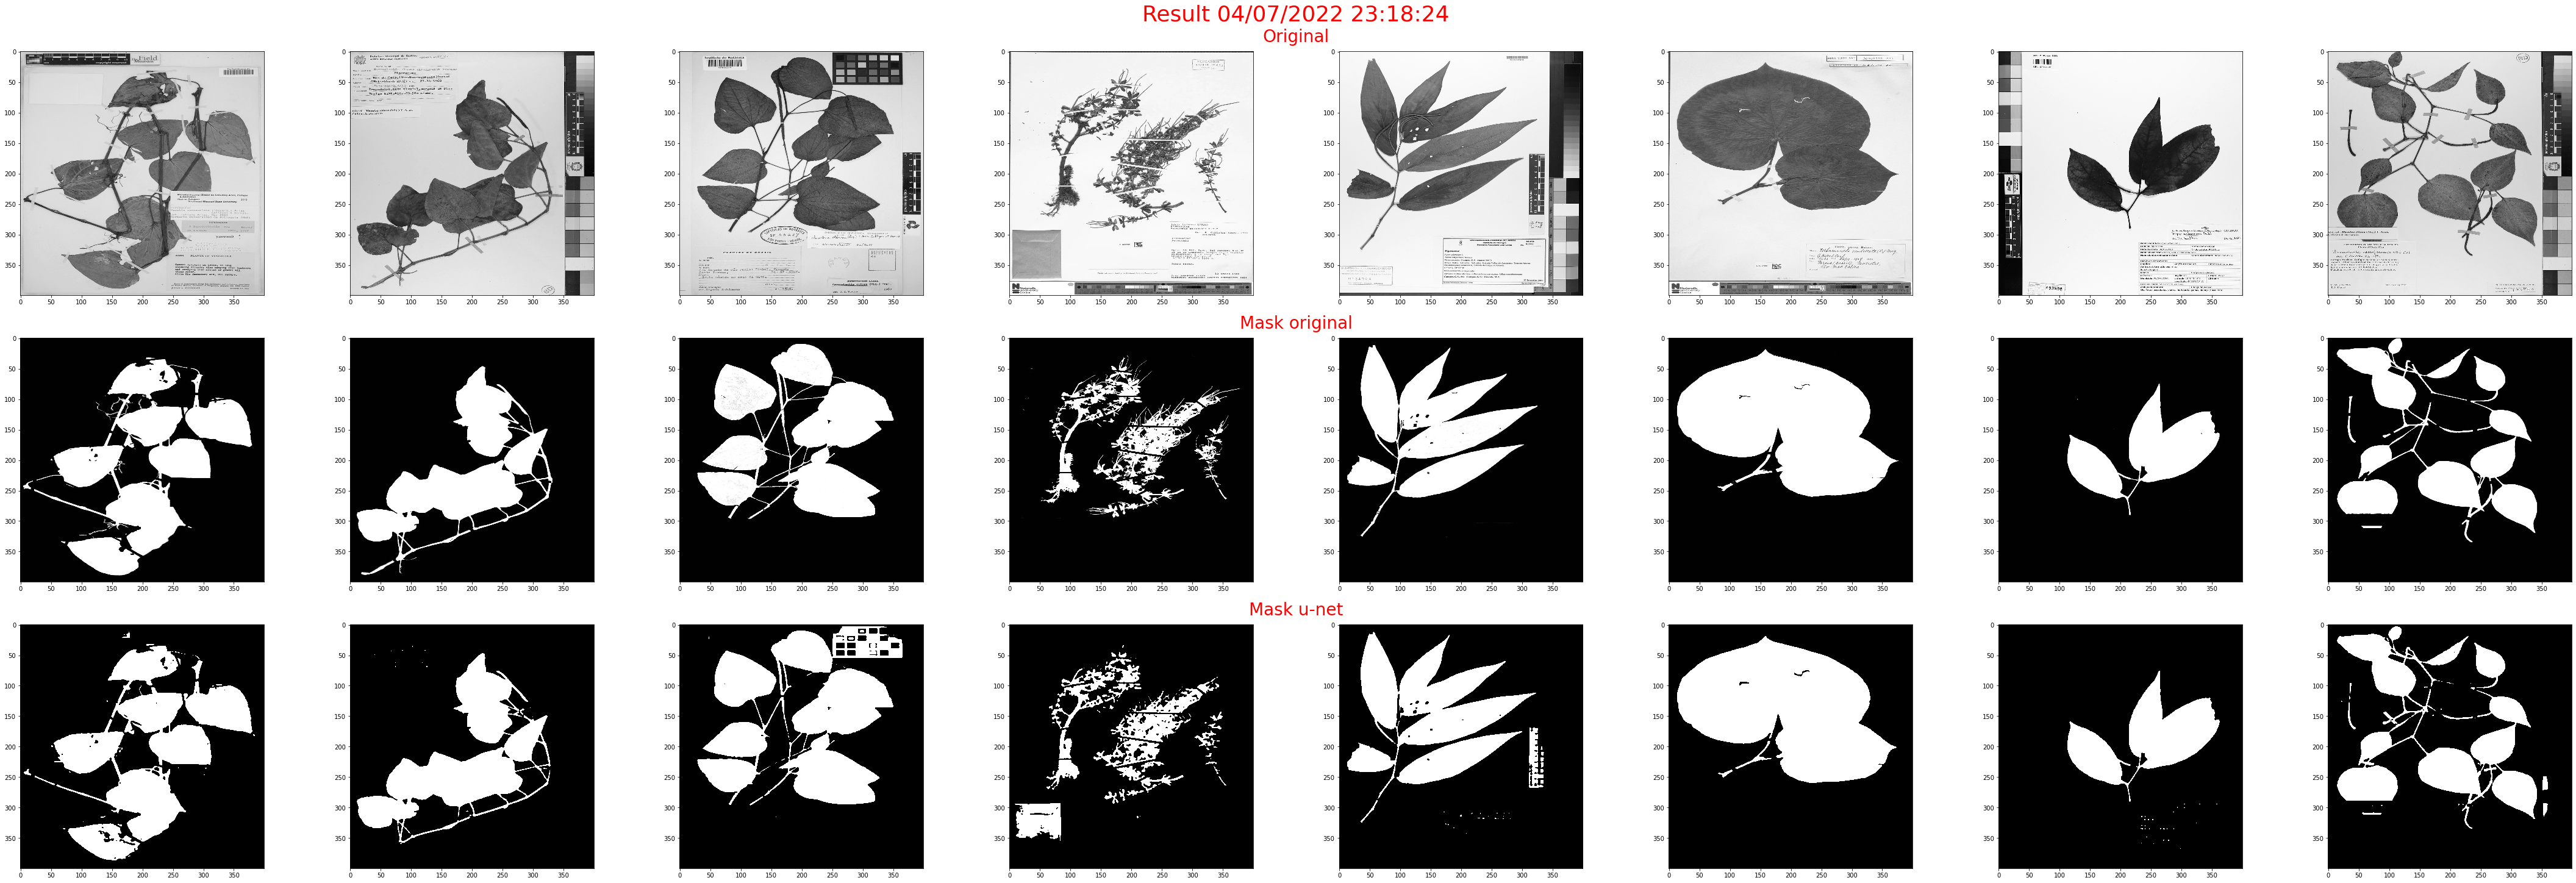

In [22]:
fig = matplotlib.pyplot.figure(constrained_layout=True, figsize=(60, 20))
fig.suptitle(f"Result {datetime.datetime.now().strftime('%d/%m/%Y %H:%M:%S')}", fontsize=36, color="r")

subfigs = fig.subfigures(nrows=3, ncols=1)
titles = ["Original", "Mask original", "Mask u-net"]
for i, subfig in enumerate(subfigs):
    subfig.suptitle(titles[i], fontsize=28, color="r")

    axs = subfig.subplots(nrows=1, ncols=8)
    for j, ax in enumerate(axs):
        if i == 0:
            test_img = X_test[j,:,:,:].reshape((1, image_size, image_size, 1))
            ax.imshow(skimage.img_as_ubyte(test_img[0,:,:,0]), cmap = "gray")
        elif i == 1:
            test_mask = Y_test[j,:,:,:].reshape((1, image_size, image_size, 1))
            ax.imshow(skimage.img_as_ubyte(test_mask[0,:,:,0]), cmap = "gray")
        elif i == 2:
            test_img = X_test[j,:,:,:].reshape((1, image_size, image_size, 1))
            pred_mask = model.predict(test_img)[0,:,:,0]
            pred_mask = numpy.uint8(pred_mask > 0.5)
            ax.imshow(pred_mask, cmap = "gray")
fig.savefig(f"{path_outfile}.png")        

### File .txt

In [23]:
try:
    with open(f"{path_outfile}.txt", "w") as outfile:
        outfile.write(f"unet filename={unet_filename}\n")    
        outfile.write(f"X: {X.shape}, X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}\n")
        outfile.write(f"learning_rate={learning_rate}, batch_size={batch_size}\n")    
        outfile.write(f"epochs={epochs}, steps={steps_per_epoch}\n")    
        outfile.write(f"============================================\n")    
        outfile.write(f"Jaccard distance (IoU) train: {iou_train}\n")
        outfile.write(f"Dice coeffient train: {dice_train}\n")
        outfile.write(f"Jaccard distance (IoU) validation: {iou_val}\n")
        outfile.write(f"Dice coeffient validation: {dice_val}\n")
        outfile.write(f"Jaccard distance (IoU) test: {iou_test}\n")
        outfile.write(f"Dice coeffient test: {dice_test}\n")
        outfile.close()
except:
    raise SystemError(f"fail in create outfile {path_outfile}")    


### Generate mask of each image

In [1]:
save_all_images(X_test, Y_test, "test") 
save_all_images(X_val, Y_val, "val")
print(f"folder {path_outfile} created")

NameError: name 'save_all_images' is not defined